# General instructions for all labs

1. To turn in:
 - this python notebook, filled out (2 pts)
 - a *standalone* PDF report that contains all the plots, and the answers to all the discussion questions (2 pts)

2. Use of ChatGPT / CoPilot / etc:
   - Allowed, but you own everything that is generated
   - This means that any part of the solution can be asked in the quiz. It can be as detailed as "What was the batch size you used in training" or specific as "what exactly does masking do in this case?" Any discussion question is also game for a quiz question.
   - If I find AI usage to be excessive. I can individually drag any of you in for a 1-1 meeting, in which I grill you on your code. If it looks like irresponsible copy/pasting, without proper understanding, I reserve the right to drastically lower your grade, or even submit cases to GGAC for ethical review.
  
3. Use of peer collaboration:
   - In general not allowed. (Discussion / comparing answers is ok, but work on actual coding independently.)
   - Exceptions can be made if you all wrote your own training script, but 1. it takes forever to train or 2. you don't have great compute resources. Then you can share a trained model amongst yourself *and declare it on your pdf*. However, the code for training *still must be written by yourself*
     




# Lab 3: Scalable Retrieval with Project Gutenberg

Modern AI systems don’t just generate answers — they rely on **retrieval** to find the right context before generation. Whether you’re building a search engine, a recommendation system, or a Retrieval-Augmented Generation (RAG) pipeline, the quality and speed of retrieval often determine how useful the final system will be.

In this lab, you’ll explore the core ideas of **scalable** retrieval using Project Gutenberg texts. Books are long, hierarchical, and varied — which makes them an excellent testbed for learning how to index, search, and evaluate retrieval aton, or just keep it high-level so the reranker is an assignment step?
tudents can *see* the difference between the two structures?
letions spelled out as mini-exercises)?


## 📚 The Project Gutenberg Corpus

For this lab, we will be working with texts from **Project Gutenberg**, a large collection of public-domain books. Project Gutenberg has been digitizing and distributing literary works since 1971, making it one of the oldest and largest open digital libraries. The collection spans over **70,000 works**, ranging from classic literature to historical documents.

Because the raw Project Gutenberg site can be tricky to scrape (inconsistent file formats, encodings, and compression), we’ll use a cleaned dataset hosted on Kaggle:

👉 [Project Gutenberg – Over 70,000 Books (Kaggle Dataset)](https://www.kaggle.com/datasets/jasonheesanglee/gutenberg-over-70000)

This version provides a consolidated, reproducible collection of the corpus, which avoids many of the Unicode and file format errors students encounter when downloading directly from gutenberg.org.

We’ll use this dataset as our **source corpus** for chunking, embedding, and retrieval experiments.



## Part 1: Download and Inspect the Data

1. **Download the dataset**

   * Use the Kaggle link above: [Project Gutenberg – Over 70,000 Books](https://www.kaggle.com/datasets/jasonheesanglee/gutenberg-over-70000).
   * Unzip the dataset into a directory on your computer. You should see:

     * Many book files in `.pkl` format (each file contains the text of a book).
     * A metadata file called `gutenberg_over_70000_metadata.csv`.

2. **Inspect the book files and metadata**

   * Scripts are provided to walk through the directory and preview the contents of `.pkl` files (e.g., first 100 characters or tokens).
   * The metadata file contains details such as book ID, title, and author.
   * Run them and look around a bit.

3. **Load the data**
   * You will extend these inspection scripts to combine the book text and metadata into a single data structure:

     * **Key:** book number (ID)
     * **Value:** dictionary with both the text and metadata details.
    **You may not want to load all the data at once, as that is very memory intensive. Just have a natural break point at, say, 1000 books, which you can remove later once we decide to modify this function to be more efficient.**



In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
import os
import pickle
import pandas as pd

def load_metadata(root_dir):
    filepath = os.path.join(root_dir, 'gutenberg_over_70000_metadata.csv')
    try:
        df = pd.read_csv(filepath)

        print("\nFilepath:", filepath)
        print(df.head(10))          # Show first 10 rows
        print("Total rows:", len(df))

    except Exception as e:
        print(f"Error opening {filepath}: {e}")

def preview_pkl_files(root_dir):
    """
    Traverse root_dir and subdirectories, open .pkl files,
    and print a preview of the first 100 characters or words.
    """
    for subdir, _, files in os.walk(root_dir):
        for file in files:
            if file.endswith(".pkl"):
                filepath = os.path.join(subdir, file)
                try:
                    with open(filepath, "rb") as f:
                        data = pickle.load(f)

                    print('\n',filepath, data[:10],len(data))

                except Exception as e:
                    print(f"Error opening {filepath}: {e}")

# Example usage

load_metadata('drive/MyDrive/archive/archive/')
# preview_pkl_files("drive/MyDrive/archive/archive/")



Filepath: drive/MyDrive/archive/archive/gutenberg_over_70000_metadata.csv
   Unnamed: 0  Book Num                                         Book Title  \
0           0         1  The Declaration of Independence of the United ...   
1           1         2  The United States Bill of Rights by United States   
2           2         3  John F. Kennedy's Inaugural Address by John F....   
3           3         4    Lincoln's Gettysburg Address by Abraham Lincoln   
4           4         5    The United States Constitution by United States   
5           5         6  Give Me Liberty or Give Me Death by Patrick Henry   
6           6         7                              The Mayflower Compact   
7           7         8  Abraham Lincoln's Second Inaugural Address by ...   
8           8         9  Abraham Lincoln's First Inaugural Address by A...   
9           9        10                The King James Version of the Bible   

  Language                              Author Original Publicatio



## 📖 From Text to Embeddings

Note that actually loading the raw text of all the books is extremely cumbersome, and also not that useful for retrieval. Instead, for retrieval systems, we don’t search directly over words — we search in **embedding space**, where each passage of text is represented as a dense vector.

Why do we need **chunking**?

* Embedding models have a **fixed input size** (typically 512–1024 tokens). A whole book is far too long to fit.
* Even if a model could process the entire book, a single embedding would dilute meaning — specific details would get lost.
* By splitting the book into smaller, overlapping passages (e.g. 500 words with 50 words overlap), we keep each chunk semantically coherent and within the model’s capacity.

Why do we need **aggregation**?

* If we only keep passage-level embeddings, retrieval becomes more expensive (millions of vectors).
* Sometimes we want a **compact representation** of the entire book (for catalog search, or as a coarse filter before drilling down).
* Aggregating embeddings — for example by **averaging** all chunk embeddings — provides this compact representation while still reflecting the book’s overall content.
* Averaging is a simple and widely used method: it balances the contributions of all chunks without blowing up dimensionality. Other methods (max pooling, weighted averaging, multi-vector representations) exist, but averaging is the most practical starting point.

---
--

Since entire books are far too long to embed directly, we need to:

1. **Chunk** the book into smaller passages (e.g. \~500 words each, with overlap).
2. **Embed** each passage using a pretrained model.
3. **Aggregate** the embeddings into a single book-level vector (e.g. by averaging).

Computing embeddings for all chunks can be expensive. To make this feasible, we will **subsample** by taking only the first *N* chunks (e.g. 000) per book. This reduces memory and runtime while still giving a representative eme students?



### Your Task

* First, look over the two functions offered to you below. You can use them, modify them, or rewrite your own functions. If you use these ones, please fill out the prompts in the comments, as you could be asked about it later.
* Next, modify your loading function from above to load the embedding computed from the text, rather than the entire text itself. You should notice that memory does not grow nearly as large.

Once it is all loaded, you can save it in a pkl file, to be easily loaded in the future.

This step can take a while. You may not want to do it last minute.


In [13]:
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.preprocessing import normalize

model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

def chunk_text(text, chunk_size=500, overlap=50, max_num_chunks = 20):
    """
    What does this function do?
    This function returns vector of chunks for size chunk_size and overlap of overlap. Here it'll only return first 20 chunks.

    What is the input?
    We input the text of the respective book, chunk_size and overlap.

    What is the output?
    A vector of chunks (max of 20 chunks)

    """
    words = text.split()
    chunks = []
    start = 0
    while start < len(words) and len(chunks) < max_num_chunks:
        end = min(start + chunk_size, len(words))
        chunk = " ".join(words[start:end])
        chunks.append(chunk)
        start += chunk_size - overlap  # slide window with overlap
    return chunks

def embed_book(text, chunk_size=500, overlap=50, aggregate="mean"):
    """
    What does this function do?
    This function returns the embedding of the book. It'll be the mean of the embeddings of the chunks. And the final embedding will be normalized.

    What is the input?
    We input the text of the respective book, chunk_size and overlap.

    What is the output?
    A vector of embedding of the book. So, it'll result in one embedding vector for a single book.
    """

    chunks = chunk_text(text, chunk_size=chunk_size, overlap=overlap)
    embeddings = model.encode(chunks, convert_to_numpy=True)
    embeddings = np.mean(embeddings,axis=0)
    embeddings = embeddings.reshape(1, -1)
    embeddings = normalize(embeddings, norm='l2', axis=1)[0]
    return embeddings

"""
# --- Example usage ---
sample_text = books['167']['text']

chunk_embeddings = embed_book(sample_text)

print("Number of chunks:", len(chunk_embeddings))      # depends on chunk_size
print("First chunk embedding shape:", chunk_embeddings[0].shape)
"""

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

'\n# --- Example usage ---\nsample_text = books[\'167\'][\'text\']\n\nchunk_embeddings = embed_book(sample_text)\n\nprint("Number of chunks:", len(chunk_embeddings))      # depends on chunk_size\nprint("First chunk embedding shape:", chunk_embeddings[0].shape)\n'

In [14]:
def embed_text(text):
    return model.encode(text, convert_to_numpy=True)

def fill_data(root_dir,combined_data,metadata_df):
    i=0
    for subdir, _, files in os.walk(root_dir):
        for file in files:
            if file.endswith(".pkl"):
                filepath = os.path.join(subdir, file)
                try:
                    with open(filepath, "rb") as f:
                        data = pickle.load(f)
                        id = file.split('_')[0]

                        if not id.isdigit():
                          continue
                        book_id = int(id)
                        row = metadata_df[metadata_df['Book Num'] == int(book_id)]
                        if not row.empty:
                            combined_data[i].append({id:{"embeddings":embed_text(data),"metadata":row.to_dict(orient='records')[0]}})
                            i+=1

                except Exception as e:
                    print(f"Error opening {filepath}: {e}")

metadata_df = pd.read_csv("drive/MyDrive/archive/archive/gutenberg_over_70000_metadata.csv")
combined_data = []
fill_data("drive/MyDrive/archive/archive/",combined_data,metadata_df)


KeyboardInterrupt: 

In [15]:
with open("drive/MyDrive/book_embeddings.pkl", "rb") as f:
  data = pickle.load(f)
  #print(list(data.values())[0])
for i, items in enumerate(data.items()):
  print(items)
  break

(23851, {'embedding': array([-5.69922999e-02,  1.61253251e-02, -2.87103839e-02, -4.03664298e-02,
       -2.93172039e-02,  1.52531294e-02, -4.49211299e-02,  4.67788875e-02,
        1.83770545e-02,  7.35672365e-04,  4.18057665e-02, -2.01929342e-02,
       -7.60863069e-03, -3.80096100e-02, -5.88160753e-02, -3.13640460e-02,
        1.47099863e-03,  2.89883222e-02,  1.66156702e-02,  6.03863075e-02,
        7.65506998e-02, -3.10416780e-02, -2.77389642e-02,  4.56394330e-02,
       -2.06020921e-02,  6.98745251e-03, -2.89425813e-02, -1.68044900e-03,
       -4.15529683e-02, -3.07998750e-02, -1.37577951e-02, -3.90788820e-03,
        4.09416705e-02, -2.38439776e-02,  1.61852110e-02,  8.63827206e-03,
        4.43309546e-02, -1.59478858e-02, -1.32634146e-02,  4.96971272e-02,
       -4.92832325e-02, -1.09561104e-02, -7.85261840e-02,  2.59375162e-02,
       -7.59532384e-04, -3.30990888e-02,  2.17919089e-02,  3.30215469e-02,
       -2.82769836e-02,  1.88528188e-02, -1.96230002e-02,  3.55053390e-03,
   

## Part 1 – Step 1: Build a Flat k-NN Graph

1. **Pairwise Distances**

   * In your notebook, write out the underlying equations for this computation.
   * Comment on the computational and memory complexity of this approach (it is $O(m^2)$ in both time and space, where $m$ is the number of books).
   * Make sure you understand the math — don’t just memorize it. I may ask you to reproduce it.

2. **Visualization with PCA**

   * Use PCA to reduce the embeddings to 2D, and plot the books in this space.
   * Instead of labeling points with IDs, annotate them with their book titles from the metadata. For example:

     ```python
     plt.text(embedding_2d[i, 0], embedding_2d[i, 1], book_embs[label]['metadata']['Book Title'], fontsize=6, alpha=0.7)
     ```
   * Comment on the geometry and clustering of these visual embeddings. Do they make sense?

3. **Nearest Neighbor Graph**

   * Create a nearest neighbor graph using `networkx`.
   * Each node corresponds to a book embedding.
   * You may connect nodes in one of two ways:

     * **Fixed degree (k-NN):** Connect each node to its $d$ closest neighbors, where $d$ is a hyperparameter (e.g. 5, 10, 20).
     * **Distance threshold:** Connect each node to any other node whose distance is less than a threshold $\varepsilon$, for example the 15th percentile of all pairwise distances.
   * Instead of plotting the raw graph with all its edges (which quickly becomes unreadable), visualize the graph structure using its adjacency matrix.

4. **Discussion**

   * Comment on the pros and cons of constructing an NN graph in each of the two ways.
   * How sensitive is the graph structure to the choice of $d$ or $\varepsilon$?
   * Compare how graph connectivity changes with the hyperparameter (clusters vs. isolated nodes).



### Cosine Distance Formula

The **cosine distance** between two vectors **A** and **B** is defined as:

$$
\text{cosine\_distance}(A, B) = 1 - \frac{A \cdot B}{\|A\| \, \|B\|}
$$

---

| Cosine Similarity | Cosine Distance | Meaning |
|-------------------|----------------|----------|
| 1.0 | 0.0 | Vectors point in the **same direction** → **identical** |
| 0.8 | 0.2 | **Highly similar** vectors |
| 0.0 | 1.0 | **Orthogonal** vectors → **no relation** |
| -1.0 | 2.0 | **Opposite directions** (completely dissimilar) |

> Lower cosine distance = more similar vectors  
> Higher cosine distance = more dissimilar vectors


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def visualize_embeddings(book_embs, max_books=100):
    titles = []
    avg_embeddings = []

    for i, data in enumerate(book_embs.items()):
        if i >= max_books:
            break

        emb = data[1]["embedding"]
        if emb is None or not isinstance(emb, np.ndarray):
            continue

        emb = normalize(emb.reshape(1,-1), norm='l2', axis=1)[0]

        avg_emb = emb

        avg_embeddings.append(avg_emb)
        titles.append(data[1]["metadata"]["Book Title"])

    if len(avg_embeddings) == 0:
        print("⚠️ No embeddings found for visualization.")
        return

    avg_embeddings = np.array(avg_embeddings)

    # Reduce dimensions to 2D
    pca = PCA(n_components=2)
    embedding_2d = pca.fit_transform(avg_embeddings)

    # Plot
    plt.figure(figsize=(10, 8))
    plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], s=10, alpha=0.5)
    labels_to_annotate = [0, 5, 10]
    for i in range(0,len(embedding_2d),500):
        plt.text(embedding_2d[i, 0] + 0.02,
                embedding_2d[i, 1] + 0.02,
                f"{titles[i]}",
                fontsize=9,
                color='red')

    plt.title("Book Embeddings Visualized with PCA")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.show()


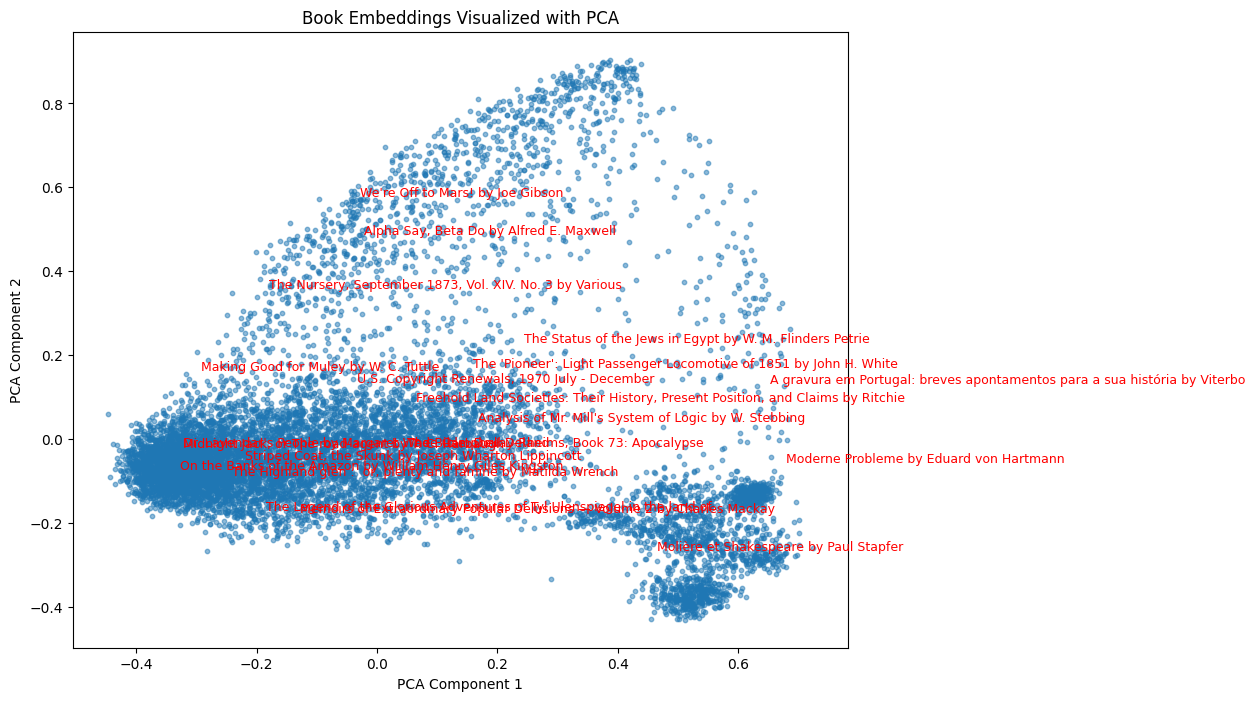

In [17]:
with open("drive/MyDrive/book_embeddings.pkl", "rb") as f:
  combined_data = pickle.load(f)
visualize_embeddings(combined_data, max_books=10000)

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.metrics.pairwise import cosine_distances
from sklearn.decomposition import PCA

def build_nearest_neighbor_graph(book_embs, method="knn", k=5, distance_percentile=15, max_books=200):

    titles = []
    avg_embeddings = []

    for i, data in enumerate(book_embs.items()):
        if i >= max_books:
            break

        emb = data[1]["embedding"]
        if emb is None or not isinstance(emb, np.ndarray):
            continue
        emb = normalize(emb.reshape(1,-1), norm='l2', axis=1)[0]
        avg_emb = emb
        avg_embeddings.append(avg_emb)
        titles.append(data[1]["metadata"]["Book Title"])

    if len(avg_embeddings) == 0:
        raise ValueError("No valid embeddings found to build the graph.")

    avg_embeddings = np.array(avg_embeddings)

    distances = cosine_distances(avg_embeddings)

    # Build graph
    G = nx.Graph()
    for i, title in enumerate(titles):
        G.add_node(i, title=title)

    if method == "knn":
        for i in range(len(titles)):
            neighbor_ids = np.argsort(distances[i])[1:k+1]
            for j in neighbor_ids:
                G.add_edge(i, j, weight=distances[i, j])
            # possible_neighbors = [j for j in range(len(titles)) if j != i]
            # neighbor_ids = np.random.choice(possible_neighbors, size=k, replace=False)
            # for j in neighbor_ids:
            #     G.add_edge(i, j, weight=distances[i, j])
    elif method == "threshold":
        threshold = np.percentile(distances, distance_percentile)
        for i in range(len(titles)):
            for j in range(i+1, len(titles)):
                if distances[i, j] < threshold:
                    G.add_edge(i, j, weight=distances[i, j])
    else:
        raise ValueError("Method must be 'knn' or 'threshold'.")

    return G, titles, distances


def visualize_adjacency_matrix(G):
    """
    Visualize adjacency matrix of the graph.
    """
    adj_matrix = nx.to_numpy_array(G)
    plt.figure(figsize=(8, 8))
    plt.spy(adj_matrix, markersize=0.5, markeredgecolor='black')
    plt.title("Adjacency Matrix of Nearest Neighbor Graph")
    plt.xlabel("Books")
    plt.ylabel("Books")
    plt.show()


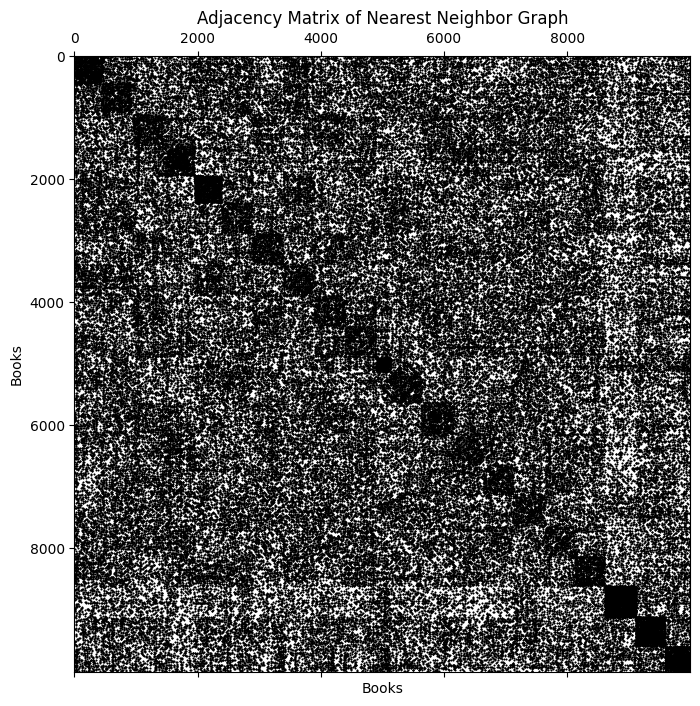

In [33]:
G, titles, distances = build_nearest_neighbor_graph(
    combined_data,
    method="knn",
    k=10,
    max_books=10000
)

visualize_adjacency_matrix(G)


## Part 1 Step 2. **Perform NN search over the graph**

1. Given a **query vector**, traverse the graph to find the nearest neighbors.  

2. First, perform **exact search**:  
   * Embed the query.  
   * Compute squared distances to all book embeddings.  
   * Find and print the 5 nearest neighbors.  
   * Use Google (or another source) to verify whether these books are actually related to your query summary.  

3. Next, try an **approximate search** using *NN descent*:  
   * Start from a random node.  
   * Look for the neighbor that is closest to the query node.  
   * Keep moving until you can’t find a closer neighbor.  
   * Return the path of visited nodes and the final result.  

4. **Discussion:**  
   * What is the computational complexity of finding the exact *d* neighbors for each query?  
   * How could approximate nearest neighbors reduce this complexity?  
   * What problems can occur with approximate NN (e.g., local optima)?  
   * How could we bypass these problems (e.g., by using more than one random seed)?  

5. **Visualization (optional):** Plot the query and its connected neighbors on your PCA projection of the embeddings.

```

# --- Query text ---
query = """In a near-future world where borders constantly shift due to climate change
and political unrest, a young cartographer named Elara is recruited by an international
coalition to create the first “living map” — a dynamic atlas that redraws itself in real time.
As she works, she discovers that the map doesn’t just reflect the world, but begins to shape it:
cities vanish from memory, coastlines retreat overnight, and entire communities are erased when
they no longer appear on her charts. Torn between her duty to her employers and her conscience,
Elara sets out on a journey across collapsing nations to uncover who is really controlling the
map — and whether she can break the paradox before the world is redrawn beyond recognition."""

```



In [21]:
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_distances

model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

def find_nearest_neighbors(query, book_embs, top_k=5, max_books=500):

    query_emb = model.encode([query], convert_to_numpy=True)
    query_emb = query_emb[0]

    titles = []
    avg_embeddings = []

    for i, (book_id, data) in enumerate(book_embs.items()):
        if i >= max_books:
            break

        emb = data["embedding"]
        emb = normalize(emb.reshape(1,-1), norm='l2', axis=1)[0]
        avg_emb = emb
        avg_embeddings.append(avg_emb)
        titles.append(data["metadata"]["Book Title"])

    avg_embeddings = np.array(avg_embeddings)

    distances = cosine_distances([query_emb], avg_embeddings)[0]

    nearest_ids = np.argsort(distances)[:top_k]

    top_results = [(titles[i], distances[i]) for i in nearest_ids]

    print("\n🔍 Top Nearest Books:")
    for title, dist in top_results:
        print(f"• {title} — distance: {dist:.4f}")

    return top_results


In [22]:
query = "In a near-future world where borders constantly shift due to climate change and political unrest, a young cartographer named Elara is recruited by an international coalition to create the first “living map” — a dynamic atlas that redraws itself in real time. As she works, she discovers that the map doesn’t just reflect the world, but begins to shape it: cities vanish from memory, coastlines retreat overnight, and entire communities are erased when they no longer appear on her charts. Torn between her duty to her employers and her conscience, Elara sets out on a journey across collapsing nations to uncover who is really controlling the map — and whether she can break the paradox before the world is redrawn beyond recognition."
top_books = find_nearest_neighbors(query, combined_data, top_k=5, max_books=10000)



🔍 Top Nearest Books:
• The Boston School Atlas, Embracing a Compendium of Geography by B. Franklin Edmands — distance: 0.5371
• The Future in America: A Search After Realities by H. G. Wells — distance: 0.5679
• Faery Lands of the South Seas by James Norman Hall and Charles Nordhoff — distance: 0.5700
• Brazil and the River Plate in 1868 by William Hadfield — distance: 0.5922
• Under the Southern Cross by Maturin M. Ballou — distance: 0.5971


Google search gives "The Cartographer's Journey | Fiction " as the answer.

In [23]:
import numpy as np
import random
from sklearn.metrics.pairwise import cosine_distances

def approximate_nn_search(query, G, book_embs, titles, model, max_steps=20,max_books=500):

    query_emb = model.encode([query], convert_to_numpy=True)[0]

    avg_embeddings = []
    for i, (book_id, data) in enumerate(book_embs.items()):
        if i >= max_books:
            break

        emb = data["embedding"]
        emb = normalize(emb.reshape(1,-1), norm='l2', axis=1)[0]
        avg_emb = emb
        avg_embeddings.append(avg_emb)
        # titles.append(data["metadata"]["Book Title"])
    avg_embeddings = np.array(avg_embeddings)

    current = random.randint(0, len(titles) - 1)
    path = [current]

    def dist(a, b):
        return cosine_distances([a], [b])[0][0]

    best_dist = dist(query_emb, avg_embeddings[current])

    print(f"🔍 Starting from node {current}: {titles[current]} (dist={best_dist:.4f})")

    for step in range(max_steps):
        neighbors = list(G.neighbors(current))
        if not neighbors:
            print("No more neighbors to explore.")
            break

        neighbor_dists = [(n, dist(query_emb, avg_embeddings[n])) for n in neighbors]
        best_neighbor, best_neighbor_dist = min(neighbor_dists, key=lambda x: x[1])

        if best_neighbor_dist >= best_dist:
            print(f"🛑 Stopping: no closer neighbor found at step {step}.")
            break

        current = best_neighbor
        best_dist = best_neighbor_dist
        path.append(current)
        print(f"➡️ Step {step+1}: moved to {titles[current]} (dist={best_dist:.4f})")

    print(f"\n✅ Final nearest neighbor: {titles[current]} (distance={best_dist:.4f})")
    print("Traversal Path:")
    for idx in path:
        print(f"• {titles[idx]}")

    return path, current


In [34]:
print(len(titles))
print(len(G))

10000
10000


In [35]:
query = "In a near-future world where borders constantly shift due to climate change and political unrest, a young cartographer named Elara is recruited by an international coalition to create the first “living map” — a dynamic atlas that redraws itself in real time. As she works, she discovers that the map doesn’t just reflect the world, but begins to shape it: cities vanish from memory, coastlines retreat overnight, and entire communities are erased when they no longer appear on her charts. Torn between her duty to her employers and her conscience, Elara sets out on a journey across collapsing nations to uncover who is really controlling the map — and whether she can break the paradox before the world is redrawn beyond recognition."

path, final_node = approximate_nn_search(
    query=query,
    G=G,                       # your nearest neighbor graph from earlier
    book_embs=combined_data,   # dictionary with text + embeddings
    titles=titles,             # list of titles corresponding to nodes
    model=model,
    max_steps=15,
    max_books=10000
)


🔍 Starting from node 9246: Clarissa Harlowe; or the history of a young lady — Volume 7 by Samuel Richardson (dist=0.8640)
➡️ Step 1: moved to The Letters of Robert Louis Stevenson — Volume 2 by Robert Louis Stevenson (dist=0.7580)
➡️ Step 2: moved to Down at Caxton's by William A. McDermott (dist=0.6632)
🛑 Stopping: no closer neighbor found at step 2.

✅ Final nearest neighbor: Down at Caxton's by William A. McDermott (distance=0.6632)
Traversal Path:
• Clarissa Harlowe; or the history of a young lady — Volume 7 by Samuel Richardson
• The Letters of Robert Louis Stevenson — Volume 2 by Robert Louis Stevenson
• Down at Caxton's by William A. McDermott


In [36]:
import numpy as np
import random
import time, tracemalloc




def profile(fn, fn_name, *args, **kwargs):
    print('profile',fn_name)
    tracemalloc.start()
    t0 = time.perf_counter()
    result = fn(*args, **kwargs)   # run the function
    t1 = time.perf_counter()
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    print(f"{fn_name} took {t1 - t0:.4f}s, memory peak {peak/1e6:.2f} MB")
    return result


## Part 1 Step 3. **Add and Delete Nodes Online**

In real systems, data is not static — new documents (or books) arrive, and old ones may be removed. A good retrieval system must be able to **update its index online** without rebuilding everything from scratch.  

1. **Exact insertion and deletion**  
   * Insert a new node by computing its distance to **all existing nodes**.  
     - Find its nearest neighbors (e.g. top-k or within an ε-threshold).  
     - Connect it to those neighbors in the graph.  
   * Delete a node by removing it and repairing its neighbors.  
     - If nodes lose important edges (e.g. drop below degree k), recompute distances among affected neighbors to re-establish the k-NN property.  
   * **Question:** What is the computational complexity of inserting or deleting nodes *exactly* in this way? How does this scale as the graph grows?  

2. **Approximate insertion and deletion**  
   * Instead of comparing against all nodes:  
     - Start from a random entry node.  
     - Traverse the graph greedily, moving to neighbors closer to the new node.  
     - Use the visited nodes as candidates for edges.  
   * For deletion, simply remove the node and its edges without full repair, letting future approximate traversals fill in missing connections.  
   * **Question:** Where do the computational reductions come from in this approximate version? What trade-offs are introduced (e.g. possible missed neighbors, local optima)?  

3. **Discussion**  
   * Why is online add/delete functionality important in real retrieval systems?  
   * Compare the costs of exact vs approximate methods. In what scenarios would exact updates be necessary, and when is approximation acceptable?  


In [37]:
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances

def insert_node(G, embeddings, new_embedding, metadata, k=5):

    new_index = len(embeddings)
    G.add_node(new_index, **metadata)

    distances = euclidean_distances([new_embedding], embeddings)[0]

    neighbors = np.argsort(distances)[:k]

    for j in neighbors:
        dist = distances[j]
        G.add_edge(new_index, j, weight=dist)

    embeddings = np.vstack([embeddings, new_embedding])

    print(f"Inserted node {new_index} ({metadata.get('Book Title', 'Unknown')}) connected to {k} neighbors.")
    return G, embeddings


def delete_node(G, embeddings, node_id, k=5):

    if node_id not in G:
        print(f"Node {node_id} not found.")
        return G, embeddings

    affected = list(G.neighbors(node_id))
    G.remove_node(node_id)

    embeddings = np.delete(embeddings, node_id, axis=0)

    mapping = {old: new for new, old in enumerate(G.nodes())}
    G = nx.relabel_nodes(G, mapping)

    print(f"Deleted node {node_id}. Repairing {len(affected)} neighbors...")
    for i in affected:
        if i >= len(embeddings):
            continue
        distances = euclidean_distances([embeddings[i]], embeddings)[0]
        neighbors = np.argsort(distances)[1:k+1]  # skip self
        for j in list(G.neighbors(i)):
            G.remove_edge(i, j)
        for j in neighbors:
            if i != j:
                G.add_edge(i, j, weight=distances[j])

    print("Repair complete.")
    return G, embeddings


In [38]:
query_emb = model.encode([query], convert_to_numpy=True)[0]
embeddings = []
for i, (book_id, data) in enumerate(combined_data.items()):
    emb = data["embedding"]
    emb = normalize(emb.reshape(1,-1), norm='l2', axis=1)[0]
    embeddings.append(emb)
embeddings = np.array(embeddings)
new_emb = np.random.rand(embeddings.shape[1])  # example embedding
new_meta = {"Book Title": "Newly Added Book", "Author": "Anonymous"}

G, embeddings = insert_node(G, embeddings, new_emb, new_meta, k=5)

# Delete an existing book (say node 3)
G, embeddings = delete_node(G, embeddings, node_id=3, k=5)


Inserted node 70009 (Newly Added Book) connected to 5 neighbors.
Deleted node 3. Repairing 10 neighbors...
Repair complete.


In [39]:
import random
import numpy as np
import networkx as nx
from sklearn.metrics.pairwise import euclidean_distances

def greedy_traversal(G, embeddings, query_emb, start_node=None, max_steps=10):

    if start_node is None:
        start_node = random.choice(list(G.nodes()))

    current = start_node
    best_node = start_node
    visited = set([start_node])

    best_dist = np.linalg.norm(embeddings[best_node] - query_emb)

    for _ in range(max_steps):
        neighbors = list(G.neighbors(current))
        improved = False
        for n in neighbors:
            if n not in visited:
                visited.add(n)
                dist = np.linalg.norm(embeddings[n] - query_emb)
                if dist < best_dist:
                    best_dist = dist
                    best_node = n
                    current = n
                    improved = True
        if not improved:
            break  # no closer neighbor found — stop traversal

    return visited, best_node


def approximate_insert(G, embeddings, new_embedding, metadata, k=5, max_steps=10):

    new_index = len(embeddings)
    G.add_node(new_index, **metadata)

    visited, best_node = greedy_traversal(G, embeddings, new_embedding, max_steps=max_steps)

    visited_list = list(visited)
    distances = euclidean_distances([new_embedding], embeddings[visited_list])[0]
    nearest = np.argsort(distances)[:k]
    nearest_nodes = [visited_list[i] for i in nearest]

    for n in nearest_nodes:
        dist = np.linalg.norm(new_embedding - embeddings[n])
        G.add_edge(new_index, n, weight=dist)

    embeddings = np.vstack([embeddings, new_embedding])

    print(f"Approx inserted node {new_index} connected to {len(nearest_nodes)} local neighbors.")
    return G, embeddings


def approximate_delete(G, embeddings, node_id):

    if node_id not in G:
        print(f"Node {node_id} not found.")
        return G, embeddings

    G.remove_node(node_id)
    embeddings = np.delete(embeddings, node_id, axis=0)

    mapping = {old: new for new, old in enumerate(G.nodes())}
    G = nx.relabel_nodes(G, mapping)

    print(f"Approx deleted node {node_id}. No explicit neighborhood repair performed.")
    return G, embeddings


In [40]:
# Approximate insertion
new_emb = np.random.rand(embeddings.shape[1])
new_meta = {"Book Title": "Approx Book", "Author": "Anonymous"}
G, embeddings = approximate_insert(G, embeddings, new_emb, new_meta, k=5, max_steps=10)

# Approximate deletion
G, embeddings = approximate_delete(G, embeddings, node_id=2)


Approx inserted node 70009 connected to 5 local neighbors.
Approx deleted node 2. No explicit neighborhood repair performed.


## Part 2: **Hierarchical graphs**


So far, you have built and experimented with a **flat nearest neighbor graph**.  
Now we will move to a more scalable structure: the **Hierarchical Navigable Small-World (HNSW) graph**.  

### 🔎 What is HNSW?
HNSW is a graph-based data structure for **approximate nearest neighbor (ANN) search**.  
It extends the idea of a flat k-NN graph into a **multi-level hierarchy**, inspired by skip lists:  
- Each element is assigned a *maximum layer* at random.  
- Higher layers are sparse (few nodes, long-range connections).  
- Lower layers are dense (many nodes, local connections).  
- Searching starts at the top, then proceeds down through the levels, refining at each stage.  

This combination of *random layering* and *graph connectivity* yields very efficient nearest neighbor search.



## Part 2 Step 1: Construction of the HNSW Graph
1. **Random Level Assignment**  
   * Each node is assigned a maximum level \( L \), sampled from an exponential distribution.  
   * Most nodes only appear at the lowest level, while a few appear in many levels (acting as "hubs").  

2. **Layered Graphs**  
   * For each level \( \ell \), connect nodes to their nearest neighbors (just like in the flat k-NN graph).  
   * Higher levels have fewer nodes, so connections there act like "express lanes."  
   * Lower levels are more detailed, ensuring accuracy.  

3. **Hierarchy**  
   * The result is a stack of graphs: top layers are sparse and global, bottom layers are dense and local.  



I have given you a backbone of an HNSW that includes the build function. Answer the following questions.

 - Which layers is the densist?
 - Which layer contains the entry point?
 - What does the method sample_level return for a node? What is m_L? at graph?  

In [41]:
import numpy as np
import networkx as nx

class HNSW:
    def __init__(self, max_m=5, m_L=1.0, seed=42):
        """
        Simplified HNSW-style graph for teaching.
        """
        self.max_m = max_m
        self.m_L = m_L
        self.rng = np.random.default_rng(seed)
        self.layers = []             # list of graphs, one per layer
        self.node_levels = {}        # mapping: node_id -> max level
        self.embeddings = None       # store embeddings
        self.next_id = 0             # assign new IDs sequentially
        self.entry_point = None      # node ID at top level
        self.current_max_level = -1  # highest level index so far

    def sample_level(self):
        """Sample the maximum level for a node (exponential distribution)."""
        u = self.rng.random()
        return int(-np.log(u) * self.m_L)

    def build(self, embeddings):
        """Build HNSW from scratch."""
        m = embeddings.shape[0]
        self.embeddings = embeddings.copy()
        levels = [self.sample_level() for _ in range(m)]
        max_level = max(levels) if m > 0 else -1
        self.current_max_level = max_level

        # Create one graph per level
        self.layers = [nx.Graph() for _ in range(max_level + 1)]

        for i in range(m):
            self.node_levels[i] = levels[i]
            for L in range(levels[i] + 1):
                self.layers[L].add_node(i)

        # Connect nodes at each level
        for L in range(max_level + 1):
            nodes_at_L = [i for i in range(m) if levels[i] >= L]
            if len(nodes_at_L) <= 1:
                continue

            X = embeddings[nodes_at_L]  # shape (n_L, d)
            # Pairwise squared distances
            D = np.sum(X**2, axis=1)[:, None] + np.sum(X**2, axis=1)[None, :] - 2 * X @ X.T
            np.fill_diagonal(D, np.inf)

            nearest_matrix = np.argsort(D, axis=1)[:, :self.max_m]
            for row_idx, i in enumerate(nodes_at_L):
                for j_local in nearest_matrix[row_idx]:
                    j = nodes_at_L[j_local]
                    self.layers[L].add_edge(i, j, weight=float(D[row_idx, j_local]))

        # Choose entry point as any node at top level
        if m > 0:
            self.entry_point = max(range(m), key=lambda nid: levels[nid])
        else:
            self.entry_point = None

        self.next_id = m
        return self.layers, self.node_levels



In [42]:
import numpy as np

# Suppose you have your sentence embeddings (e.g., from SentenceTransformer)
embeddings = np.random.rand(20, 384)  # 20 books, 384-dimensional embeddings

# Initialize the HNSW graph
hnsw = HNSW(max_m=5, m_L=1.0, seed=42)

# Build the graph from embeddings
layers, node_levels = hnsw.build(embeddings)

In [43]:
for level, G in enumerate(hnsw.layers):
    print(f"Level {level}: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")


Level 0: 20 nodes, 69 edges
Level 1: 4 nodes, 10 edges
Level 2: 3 nodes, 6 edges


## Part 2 step 2

Next, add the following class functions:

### hnsw.search
1. **Start from the top layer** (which has the fewest nodes).  
2. **Greedy search**: at each step, move to the neighbor that is closest to the query.  
3. When no closer neighbor exists, **drop down one level** and continue.  
4. At the lowest layer, refine until the nearest neighbor (or set of neighbors) is found.  

This ensures a fast global-to-local search process.

---

### hnsw.insert
1. **Sample a level** for the new node.  
2. **Search**:  
   * Start from the top layer and traverse greedily to find a close entry point.  
   * At each level down to the node’s maximum level, continue refining its nearest neighbors.  
3. **Connect**:  
   * Add the new node to each of its assigned layers.  
   * Link it to its nearest neighbors in those layers (ensuring max degree is not exceeded).  

This way, new nodes integrate into both global and local structures.

---

### hnsw.delete
1. **Remove the node** from all layers in which it appears.  
2. **Reconnect neighbors** if necessary:  
   * At each layer, consider the deleted node’s neighbors.  
   * Re-link them if their degree drops below the required minimum or connectivity is at risk.  
3. In practice, many implementations avoid explicit repair and rely on redundancy in the graph to maintain accuracy.  

---

### 📝 Your Task
- Extend your code to use an **HNSW-style hierarchical graph** instead of a flat one.  
- Practice **traversal, insertion, and deletion** in this setting.  
- Compare the **search paths** between flat graphs and HNSW graphs:  
  * How many nodes are visited?  
  * How does the path length differ?  
  * How does the random layer




In [44]:
import numpy as np
import heapq
import random

class HNSW:
    def __init__(self, max_neighbors=5, max_level=3):
        self.max_neighbors = max_neighbors
        self.max_level = max_level
        self.graph = [{} for _ in range(max_level)]  # list of adjacency dicts per level
        self.embeddings = {}  # node_id → embedding

    def _distance(self, a, b):
        return np.linalg.norm(a - b)

    def _greedy_search(self, query_vec, entry_point, level):
        """Greedy search within one layer"""
        current = entry_point
        dist_current = self._distance(self.embeddings[current], query_vec)
        improved = True

        while improved:
            improved = False
            for neighbor in self.graph[level].get(current, []):
                dist_neighbor = self._distance(self.embeddings[neighbor], query_vec)
                if dist_neighbor < dist_current:
                    current = neighbor
                    dist_current = dist_neighbor
                    improved = True
        return current

    def search(self, query_vec, ef=5):
        """Multi-layer greedy search"""
        if not self.embeddings:
            return None

        entry_point = list(self.embeddings.keys())[0]
        top_layer = len(self.graph) - 1

        # Step 1: Navigate top-down
        for level in range(top_layer, 0, -1):
            entry_point = self._greedy_search(query_vec, entry_point, level)

        # Step 2: Refine at level 0
        candidates = [(self._distance(self.embeddings[entry_point], query_vec), entry_point)]
        visited = {entry_point}
        heap = [(candidates[0][0], entry_point)]

        while heap:
            dist, node = heapq.heappop(heap)
            for neighbor in self.graph[0].get(node, []):
                if neighbor not in visited:
                    visited.add(neighbor)
                    d = self._distance(self.embeddings[neighbor], query_vec)
                    heapq.heappush(heap, (d, neighbor))
                    candidates.append((d, neighbor))
                    if len(candidates) > ef:
                        candidates.sort(key=lambda x: x[0])
                        candidates = candidates[:ef]
        candidates.sort(key=lambda x: x[0])
        return candidates[:5]  # Return top 5

    def insert(self, node_id, vec):
        """Insert node with hierarchical connections"""
        self.embeddings[node_id] = vec
        node_level = random.randint(0, self.max_level - 1)
        print(f"Inserted node {node_id} at level {node_level}")

        # Find entry point
        if len(self.embeddings) == 1:
            for l in range(self.max_level):
                self.graph[l][node_id] = []
            return

        entry_point = list(self.embeddings.keys())[0]
        for level in range(self.max_level - 1, node_level, -1):
            entry_point = self._greedy_search(vec, entry_point, level)

        # Connect in each layer up to node_level
        for level in range(node_level + 1):
            candidates = []
            for other_id in self.graph[level].keys():
                if other_id == node_id:
                    continue
                dist = self._distance(vec, self.embeddings[other_id])
                candidates.append((dist, other_id))
            candidates.sort(key=lambda x: x[0])
            neighbors = [nid for _, nid in candidates[:self.max_neighbors]]

            self.graph[level][node_id] = neighbors
            for n in neighbors:
                self.graph[level][n].append(node_id)
                if len(self.graph[level][n]) > self.max_neighbors:
                    self.graph[level][n] = self.graph[level][n][:self.max_neighbors]

    def delete(self, node_id):
        """Remove node from all layers"""
        if node_id not in self.embeddings:
            print(f"Node {node_id} not found.")
            return
        del self.embeddings[node_id]

        for level in range(self.max_level):
            if node_id in self.graph[level]:
                neighbors = self.graph[level][node_id]
                del self.graph[level][node_id]
                for n in neighbors:
                    if node_id in self.graph[level].get(n, []):
                        self.graph[level][n].remove(node_id)
        print(f"Deleted node {node_id} and repaired edges.")

    def visualize_connections(self):
        for l, g in enumerate(self.graph):
            print(f"Layer {l}:")
            for node, nbrs in g.items():
                print(f"  {node} -> {nbrs}")


In [45]:
# Create HNSW
hnsw = HNSW(max_neighbors=3, max_level=3)

# Insert embeddings (random for demo)
for i in range(6):
    hnsw.insert(i, np.random.rand(5))

# Visualize
hnsw.visualize_connections()

# Search
query = np.random.rand(5)
result = hnsw.search(query)
print("\nNearest Neighbors:", result)

# Delete
hnsw.delete(3)
hnsw.visualize_connections()


Inserted node 0 at level 2
Inserted node 1 at level 0
Inserted node 2 at level 2
Inserted node 3 at level 1
Inserted node 4 at level 1
Inserted node 5 at level 1
Layer 0:
  0 -> [1, 2, 3]
  1 -> [0, 2, 3]
  2 -> [0, 1, 3]
  3 -> [0, 2, 1]
  4 -> [3, 2, 0]
  5 -> [0, 1, 3]
Layer 1:
  0 -> [2, 3, 4]
  2 -> [0, 3, 4]
  3 -> [0, 2, 4]
  4 -> [3, 2, 0]
  5 -> [0, 3, 4]
Layer 2:
  0 -> [2]
  2 -> [0]

Nearest Neighbors: [(np.float64(0.46456718632171795), 4), (np.float64(0.5797106053402398), 3), (np.float64(0.8892681565745154), 2), (np.float64(0.9876626793003398), 0), (np.float64(1.2781145345789984), 1)]
Deleted node 3 and repaired edges.
Layer 0:
  0 -> [1, 2]
  1 -> [0, 2]
  2 -> [0, 1]
  4 -> [3, 2, 0]
  5 -> [0, 1, 3]
Layer 1:
  0 -> [2, 4]
  2 -> [0, 4]
  4 -> [2, 0]
  5 -> [0, 3, 4]
Layer 2:
  0 -> [2]
  2 -> [0]


In [46]:
import numpy as np
import heapq
import random

# -----------------------------
# FLAT GRAPH (exact search)
# -----------------------------
class FlatKNN:
    def __init__(self):
        self.embeddings = {}

    def insert(self, node_id, vec):
        self.embeddings[node_id] = vec

    def search(self, query_vec, k=5):
        visited = list(self.embeddings.keys())
        dists = [(np.linalg.norm(vec - query_vec), nid)
                 for nid, vec in self.embeddings.items()]
        dists.sort(key=lambda x: x[0])
        return dists[:k], visited


# -----------------------------
# HNSW GRAPH (approximate)
# -----------------------------
class HNSW:
    def __init__(self, max_neighbors=5, max_level=3):
        self.max_neighbors = max_neighbors
        self.max_level = max_level
        self.graph = [{} for _ in range(max_level)]
        self.embeddings = {}

    def _distance(self, a, b):
        return np.linalg.norm(a - b)

    def _greedy_search(self, query_vec, entry_point, level, visited):
        current = entry_point
        dist_current = self._distance(self.embeddings[current], query_vec)
        improved = True
        while improved:
            improved = False
            for neighbor in self.graph[level].get(current, []):
                visited.add(neighbor)
                dist_neighbor = self._distance(self.embeddings[neighbor], query_vec)
                if dist_neighbor < dist_current:
                    current = neighbor
                    dist_current = dist_neighbor
                    improved = True
        return current

    def search(self, query_vec, ef=5):
        """Return (results, visited_nodes)"""
        visited = set()
        if not self.embeddings:
            return [], visited

        entry_point = list(self.embeddings.keys())[0]
        top_layer = len(self.graph) - 1

        # Top-down traversal
        for level in range(top_layer, 0, -1):
            visited.add(entry_point)
            entry_point = self._greedy_search(query_vec, entry_point, level, visited)

        # Refine at level 0
        visited.add(entry_point)
        candidates = [(self._distance(self.embeddings[entry_point], query_vec), entry_point)]
        heap = [(candidates[0][0], entry_point)]

        while heap:
            dist, node = heapq.heappop(heap)
            for neighbor in self.graph[0].get(node, []):
                if neighbor not in visited:
                    visited.add(neighbor)
                    d = self._distance(self.embeddings[neighbor], query_vec)
                    heapq.heappush(heap, (d, neighbor))
                    candidates.append((d, neighbor))
                    if len(candidates) > ef:
                        candidates.sort(key=lambda x: x[0])
                        candidates = candidates[:ef]
        candidates.sort(key=lambda x: x[0])
        return candidates[:5], visited

    def insert(self, node_id, vec):
        self.embeddings[node_id] = vec
        node_level = random.randint(0, self.max_level - 1)

        for l in range(self.max_level):
            if node_id not in self.graph[l]:
                self.graph[l][node_id] = []

        if len(self.embeddings) == 1:
            return

        entry_point = list(self.embeddings.keys())[0]
        for level in range(self.max_level - 1, node_level, -1):
            entry_point = self._greedy_search(vec, entry_point, level, set())

        for level in range(node_level + 1):
            candidates = []
            for other_id in self.graph[level].keys():
                if other_id == node_id:
                    continue
                dist = self._distance(vec, self.embeddings[other_id])
                candidates.append((dist, other_id))
            candidates.sort(key=lambda x: x[0])
            neighbors = [nid for _, nid in candidates[:self.max_neighbors]]

            self.graph[level][node_id] = neighbors
            for n in neighbors:
                self.graph[level][n].append(node_id)
                if len(self.graph[level][n]) > self.max_neighbors:
                    self.graph[level][n] = self.graph[level][n][:self.max_neighbors]


# -----------------------------
# DEMO: Compare flat vs HNSW
# -----------------------------
# Create embeddings
np.random.seed(42)
N = 50
D = 8
embs = {i: np.random.rand(D) for i in range(N)}

flat = FlatKNN()
hnsw = HNSW(max_neighbors=5, max_level=3)

for i, v in embs.items():
    flat.insert(i, v)
    hnsw.insert(i, v)

# Query
query = np.random.rand(D)

flat_results, flat_visited_nodes = flat.search(query)
hnsw_results, hnsw_visited_nodes = hnsw.search(query)

print("\n--- Results ---")
print("Flat KNN Top 5:", [nid for _, nid in flat_results])
print("HNSW Top 5:", [nid for _, nid in hnsw_results])
print("\n--- Visited Nodes ---")
print(f"Flat graph visited {len(flat_visited_nodes)} nodes.")
print(f"HNSW graph visited {len(hnsw_visited_nodes)} nodes.")



--- Results ---
Flat KNN Top 5: [20, 27, 8, 5, 39]
HNSW Top 5: [5, 4]

--- Visited Nodes ---
Flat graph visited 50 nodes.
HNSW graph visited 10 nodes.


### Questions for you

- **Layer assignment strategy:**  
  How are levels assigned to each node under this exponential scheme?  Is a node assigned to just one layer, or multiple layers? Explain the exact assignment scheme.
  What are the advantages and disadvantages of this method compared to deterministic or uniform assignments?  

- **Computational and memory bottlenecks:**  
  Where do the main costs arise (construction, traversal, updates)?  
  At which stages are these bottlenecks reduced or avoided?  
  Why is this hierarchical design favored over a single flat graph?  



## Part 3: Scalable Retrieval with FAISS

Now that you’ve built your own HNSW structure, it’s time to see how it compares to industry-strength libraries. FAISS (Facebook AI Similarity Search) is a widely used toolkit for nearest neighbor retrieval at scale. In this part, you will explore FAISS’s **built-in indexing methods** and evaluate how they differ from your own implementation.

1. **Indexing Approaches**

   * **Flat Index (Exact Search):**

     ```python
     import faiss
     d = embeddings.shape[1]   # embedding dimension
     index_flat = faiss.IndexFlatL2(d)   # exact search
     index_flat.add(embeddings)          # add all vectors
     D, I = index_flat.search(embeddings[:5], k=5)  # search first 5 queries
     ```

   * **HNSW Index (Approximate Search):**

     ```python
     index_hnsw = faiss.IndexHNSWFlat(d, 32)  # 32 = max neighbors per node
     index_hnsw.hnsw.efConstruction = 40      # build-time parameter
     index_hnsw.add(embeddings)
     D_hnsw, I_hnsw = index_hnsw.search(embeddings[:5], k=5)
     ```

2. **Comparison**

   * **Computation:** How does query speed change between the flat index and FAISS HNSW as the dataset size grows?
   * **Memory:** How much extra memory is used to store the graph structure in FAISS HNSW compared to the flat index?
   * **Quality:** How close are the retrieved neighbors from FAISS HNSW to the ground-truth neighbors found by exact search? (Measurectly measure the speed difference?
and recommendation)?


In [1]:
!pip install faiss-cpu


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 47.7 MB/s eta 0:00:00


In [2]:
import numpy as np
import faiss


In [3]:
# Example: random embeddings for demo
np.random.seed(42)
n = 1000     # number of books
d = 128      # embedding dimension
embeddings = np.random.random((n, d)).astype('float32')

# Just for reference
print("Embedding shape:", embeddings.shape)


Embedding shape: (1000, 128)


In [4]:
# Create exact L2 index
index_flat = faiss.IndexFlatL2(d)
print("Is trained?", index_flat.is_trained)  # should be True for Flat index

# Add embeddings
index_flat.add(embeddings)
print("Total vectors indexed:", index_flat.ntotal)

# Search top-5 nearest neighbors for the first 5 vectors
D_flat, I_flat = index_flat.search(embeddings[:5], k=5)

print("\nExact Search (Flat Index) Results:")
print("Indices:\n", I_flat)
print("Distances:\n", D_flat)


Is trained? True
Total vectors indexed: 1000

Exact Search (Flat Index) Results:
Indices:
 [[  0 544 307 196 990]
 [  1 139  49 218 390]
 [  2 969 870 157 431]
 [  3 516 524 238 385]
 [  4 742 835 803  23]]
Distances:
 [[ 0.       16.511444 16.620884 16.976223 16.981016]
 [ 0.       14.870398 15.513443 15.830995 15.982573]
 [ 0.       15.446987 15.537077 15.605581 16.226688]
 [ 0.       16.951797 17.157562 17.188381 17.335577]
 [ 0.       15.254282 15.484168 15.708829 15.944298]]


In [5]:
# Create HNSW Index
M = 32  # number of neighbors per node
index_hnsw = faiss.IndexHNSWFlat(d, M)

# Tune build-time parameters
index_hnsw.hnsw.efConstruction = 40  # higher = more accurate but slower
index_hnsw.hnsw.efSearch = 16        # higher = more accurate search

# Add embeddings
index_hnsw.add(embeddings)
print("Total vectors indexed (HNSW):", index_hnsw.ntotal)

# Search top-5 nearest neighbors for first 5 queries
D_hnsw, I_hnsw = index_hnsw.search(embeddings[:5], k=5)

print("\nApproximate Search (HNSW) Results:")
print("Indices:\n", I_hnsw)
print("Distances:\n", D_hnsw)


Total vectors indexed (HNSW): 1000

Approximate Search (HNSW) Results:
Indices:
 [[  0 544 307 196 990]
 [  1 139  49 218 390]
 [  2 969 870 157 431]
 [  3 516 524 238 385]
 [  4 742 835 803  23]]
Distances:
 [[ 0.       16.511444 16.620884 16.976223 16.981016]
 [ 0.       14.870398 15.513443 15.830995 15.982573]
 [ 0.       15.446986 15.537076 15.605582 16.22669 ]
 [ 0.       16.951797 17.157562 17.188381 17.335579]
 [ 0.       15.254283 15.484167 15.708829 15.944297]]


In [6]:
# Compare overlap between Flat and HNSW for first 5 queries
for i in range(5):
    overlap = len(set(I_flat[i]) & set(I_hnsw[i])) / 5
    print(f"Query {i}: overlap = {overlap * 100:.1f}%")


Query 0: overlap = 100.0%
Query 1: overlap = 100.0%
Query 2: overlap = 100.0%
Query 3: overlap = 100.0%
Query 4: overlap = 100.0%
